### **Does Value Factor (HML) Work in Chinese Stock Market?**

In [313]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 18 00:47:01 2021

@author: Bradley

Code for recurring FIN3080 Project 2 - Case 1
"""

'\nCreated on Sat July 18 00:47:01 2021\n\n@author: Bradley\n\nCode for recurring FIN3080 Project 2 - Case 1\n'

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 

月度回报率数据字段说明：
- Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准
- Trdmnt [交易月份] - 以YYYY-MM表示
- Msmvosd [月个股流通市值] - 个股的流通股数与月收盘价的乘积。 A股以人民币元计，上海B以美元计，深圳B以港币计，注意单位是千
- Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千
- Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见“回报率计算方法”
- Mretnd [不考虑现金红利再投资的月个股回报率] - 字段说明见“回报率计算方法”

In [323]:
# 读取2006年1月至2020年12月的月度股票回报率和流通市值数据
month = pd.read_csv('./case1_data/MonthReturn.csv')
month.head()

,Stkcd,Trdmnt,Msmvosd,Mretwd,Mretnd,Markettype
0,1,2006-01,8949448.48,0.034202,0.034202,4
1,1,2006-02,9640035.84,0.077165,0.077165,4
2,1,2006-03,8977635.72,-0.068713,-0.068713,4
3,1,2006-04,11105772.28,0.237049,0.237049,4
4,1,2006-05,12374198.05,0.114213,0.114213,4


In [324]:
month.columns = ['code', 'date', 'circulate', 'return1', 'return2', 'type']
month['code'] = month['code'].map(lambda s: '%06d'%s)
# month['date'] = month['date'].map(lambda s: "%d-%02d"%(s//100, s%100))
month['date'] = pd.to_datetime(month['date'])
month

,code,date,circulate,return1,return2,type
0,000001,2006-01-01,8949448.48,0.034202,0.034202,4
1,000001,2006-02-01,9640035.84,0.077165,0.077165,4
2,000001,2006-03-01,8977635.72,-0.068713,-0.068713,4
3,000001,2006-04-01,11105772.28,0.237049,0.237049,4
4,000001,2006-05-01,12374198.05,0.114213,0.114213,4
...,...,...,...,...,...,...
405859,688981,2020-11-01,61633699.96,-0.048040,-0.048040,32
405860,688981,2020-12-01,60073353.13,-0.025316,-0.025316,32
405861,689009,2020-10-01,274481.31,NaN,NaN,32
405862,689009,2020-11-01,411433.64,0.498950,0.498950,32


In [325]:
month_12 = month[month['date'].dt.month == 12]
# 半年度财报数据用于划分组合
month_6 = month[month['date'].dt.month == 6]

In [327]:
# generate median of the mainboard market
# 只保留type为1和4的股票，也就是只要主板股票
# 取一份副本，因为下面还需要用到完整的month_6数据
month_6_copy = month_6[month_6['type'].isin([1, 4])]
# 下面需要根据年份分组以求得中位数，记得是中位数，是median！！！不是mean，不是均值！因为是要根据分位数进行分组划分的！
month_6_copy['year'] = month_6_copy['date'].dt.year
month_6_copy.set_index('year', inplace=True)
month_6_copy['mean_mv'] = month_6_copy.groupby(level=0)['circulate'].median()
month_6_copy

,code,date,circulate,return1,return2,type,mean_mv
year,,,,,,,
2006,000001,2006-06-01,10654776.46,-0.138952,-0.138952,4,666109.13
2007,000001,2007-06-01,42661167.90,0.055417,0.055455,4,1683360.00
2008,000001,2008-06-01,41404945.23,-0.233849,-0.233849,4,1378859.24
2009,000001,2009-06-01,63794579.75,0.223094,0.223094,4,2142864.36
2010,000001,2010-06-01,54374986.71,0.000000,0.000000,4,2400832.35
...,...,...,...,...,...,...,...
2020,603999,2020-06-01,3427200.00,0.053097,0.053097,1,4823275.33
2020,605001,2020-06-01,1547468.80,-0.109178,-0.109178,1,4823275.33
2020,605166,2020-06-01,1250358.95,NaN,NaN,1,4823275.33


In [328]:
# 得到每年流通市值划分线（半年报流通市值）的median！
market_mean_mv = month_6_copy[['mean_mv']].drop_duplicates()
market_mean_mv.to_csv("./processed_data/case1_market_mean_mv.csv")
market_mean_mv

,mean_mv
year,
2006,666109.130
2007,1683360.000
2008,1378859.240
2009,2142864.360
2010,2400832.350
2011,3388720.185
2012,2520976.530
2013,2494599.060
2014,3496611.820


In [329]:
# 上面计算中位数只用了主板，现在要对全体A股划分区间，也就是比中位数大和小的分别划到两个区间

# 保留type为1和4和16的股票，也就是只要A股
a_share = month_6[month_6['type'].isin([1, 4, 16])]
a_share['year'] = a_share['date'].dt.year
a_share.set_index('year', inplace=True)

# 进行dataframe匹配，根据index即年份
a_share['mean_mv'] = market_mean_mv['mean_mv']
a_share

,code,date,circulate,return1,return2,type,mean_mv
year,,,,,,,
2006,000001,2006-06-01,10654776.46,-0.138952,-0.138952,4,666109.13
2007,000001,2007-06-01,42661167.90,0.055417,0.055455,4,1683360.00
2008,000001,2008-06-01,41404945.23,-0.233849,-0.233849,4,1378859.24
2009,000001,2009-06-01,63794579.75,0.223094,0.223094,4,2142864.36
2010,000001,2010-06-01,54374986.71,0.000000,0.000000,4,2400832.35
...,...,...,...,...,...,...,...
2020,603999,2020-06-01,3427200.00,0.053097,0.053097,1,4823275.33
2020,605001,2020-06-01,1547468.80,-0.109178,-0.109178,1,4823275.33
2020,605166,2020-06-01,1250358.95,NaN,NaN,1,4823275.33


In [330]:
# 得到SMB的划分，一步where解决二分类问题
a_share['SB'] = np.where(a_share['circulate'] < a_share['mean_mv'], 1, 2)
a_share.to_csv("./processed_data/case1_SMB_classification.csv", index=True)
a_share

,code,date,circulate,return1,return2,type,mean_mv,SB
year,,,,,,,,
2006,000001,2006-06-01,10654776.46,-0.138952,-0.138952,4,666109.13,2
2007,000001,2007-06-01,42661167.90,0.055417,0.055455,4,1683360.00,2
2008,000001,2008-06-01,41404945.23,-0.233849,-0.233849,4,1378859.24,2
2009,000001,2009-06-01,63794579.75,0.223094,0.223094,4,2142864.36,2
2010,000001,2010-06-01,54374986.71,0.000000,0.000000,4,2400832.35,2
...,...,...,...,...,...,...,...,...
2020,603999,2020-06-01,3427200.00,0.053097,0.053097,1,4823275.33,1
2020,605001,2020-06-01,1547468.80,-0.109178,-0.109178,1,4823275.33,1
2020,605166,2020-06-01,1250358.95,NaN,NaN,1,4823275.33,1


**Calculate book equity (numerator)**

In [331]:
# 读取财报数据，财报数据用来计算HML的分子，也就是账面值book value，而不是直接用PB的倒数计算
mv = pd.read_csv('./case1_data/statement.csv')
mv.columns = ['code', 'date', 'type', '递延所得税资产', '递延所得税负债', '优先股账面值', '所有者权益合计']
mv['code'] = mv['code'].map(lambda s: '%06d'%s)
# mv['date'] = mv['date'].map(lambda s: "%d-%02d"%(s//100, s%100))
mv['date'] = pd.to_datetime(mv['date'], format='%Y-%m')
mv

,code,date,type,递延所得税资产,递延所得税负债,优先股账面值,所有者权益合计
0,000001,2006-01-01,A,1.000889e+09,2.350486e+08,NaN,5.054411e+09
1,000001,2006-03-31,A,1.039585e+09,2.636011e+08,NaN,5.264133e+09
2,000001,2006-06-30,A,9.823611e+08,2.122933e+08,NaN,5.592040e+09
3,000001,2006-09-30,A,9.321265e+08,2.463181e+08,NaN,6.053955e+09
4,000001,2006-12-31,A,1.002643e+09,2.338121e+08,NaN,6.474463e+09
...,...,...,...,...,...,...,...
341971,688819,2020-12-31,A,4.336534e+08,3.388872e+07,NaN,7.128028e+09
341972,688981,2020-01-01,A,4.395970e+08,2.398520e+08,NaN,7.125902e+10
341973,688981,2020-06-30,A,1.911380e+08,NaN,NaN,9.330745e+10
341974,688981,2020-09-30,A,1.716030e+08,NaN,NaN,1.434151e+11


In [332]:
# 只留下年报的数据，就是12月份，同时只要type为A的财报数据
mv = mv[(mv['date'].dt.month == 12) & (mv['type'] == 'A')]
mv

,code,date,type,递延所得税资产,递延所得税负债,优先股账面值,所有者权益合计
4,000001,2006-12-31,A,1.002643e+09,2.338121e+08,NaN,6.474463e+09
9,000001,2007-12-31,A,9.943890e+08,9.854400e+07,NaN,1.300606e+10
14,000001,2008-12-31,A,1.811816e+09,3.416790e+08,NaN,1.640079e+10
19,000001,2009-12-31,A,1.582934e+09,9.452500e+07,NaN,2.046961e+10
24,000001,2010-12-31,A,1.954568e+09,1.542500e+07,NaN,3.319754e+10
...,...,...,...,...,...,...,...
341957,688677,2020-12-31,A,6.018043e+06,3.456700e+04,NaN,3.196929e+08
341961,688699,2020-12-31,A,5.285486e+06,NaN,NaN,1.085821e+09
341965,688777,2020-12-31,A,3.896367e+07,NaN,NaN,4.035127e+09
341971,688819,2020-12-31,A,4.336534e+08,3.388872e+07,NaN,7.128028e+09


In [333]:
mv.isnull().sum()

code           0
date           0
type           0
递延所得税资产      365
递延所得税负债     5154
优先股账面值     31057
所有者权益合计        0
dtype: int64

In [334]:
# 空缺值填充为0
mv.fillna(0, inplace=True)
mv.isnull().sum()

code       0
date       0
type       0
递延所得税资产    0
递延所得税负债    0
优先股账面值     0
所有者权益合计    0
dtype: int64

In [335]:
# 计算book equity，HML的分子
mv['book_equity'] = mv['所有者权益合计']+ mv['递延所得税负债'] - mv['递延所得税资产'] - mv['优先股账面值']
mv.to_csv("./processed_data/case1_book_equity.csv", index=False)
mv

,code,date,type,递延所得税资产,递延所得税负债,优先股账面值,所有者权益合计,book_equity
4,000001,2006-12-31,A,1.002643e+09,2.338121e+08,0.0,6.474463e+09,5.705632e+09
9,000001,2007-12-31,A,9.943890e+08,9.854400e+07,0.0,1.300606e+10,1.211022e+10
14,000001,2008-12-31,A,1.811816e+09,3.416790e+08,0.0,1.640079e+10,1.493065e+10
19,000001,2009-12-31,A,1.582934e+09,9.452500e+07,0.0,2.046961e+10,1.898120e+10
24,000001,2010-12-31,A,1.954568e+09,1.542500e+07,0.0,3.319754e+10,3.125839e+10
...,...,...,...,...,...,...,...,...
341957,688677,2020-12-31,A,6.018043e+06,3.456700e+04,0.0,3.196929e+08,3.137094e+08
341961,688699,2020-12-31,A,5.285486e+06,0.000000e+00,0.0,1.085821e+09,1.080536e+09
341965,688777,2020-12-31,A,3.896367e+07,0.000000e+00,0.0,4.035127e+09,3.996163e+09
341971,688819,2020-12-31,A,4.336534e+08,3.388872e+07,0.0,7.128028e+09,6.728263e+09


In [336]:
mv = pd.read_csv("./processed_data/case1_book_equity.csv")
mv['code'] = mv['code'].map(lambda s: '%06d'%s)
mv['date'] = pd.to_datetime(mv['date'])
# # 取出book equity，并使用年份作为index方便后面的merge
mv['year'] = mv['date'].dt.year
mv.sort_values(by=['code', 'year'], inplace=True)
# 使用double index方便下面匹配
mv.set_index(['code', 'year'], inplace=True)
mv

date type       递延所得税资产       递延所得税负债  优先股账面值       所有者权益合计   book_equity
code   year                                                                                
000001 2006 2006-12-31    A  1.002643e+09  2.338121e+08     0.0  6.474463e+09  5.705632e+09
       2007 2007-12-31    A  9.943890e+08  9.854400e+07     0.0  1.300606e+10  1.211022e+10
       2008 2008-12-31    A  1.811816e+09  3.416790e+08     0.0  1.640079e+10  1.493065e+10
       2009 2009-12-31    A  1.582934e+09  9.452500e+07     0.0  2.046961e+10  1.898120e+10
       2010 2010-12-31    A  1.954568e+09  1.542500e+07     0.0  3.319754e+10  3.125839e+10
...                ...  ...           ...           ...     ...           ...           ...
688677 2020 2020-12-31    A  6.018043e+06  3.456700e+04     0.0  3.196929e+08  3.137094e+08
688699 2020 2020-12-31    A  5.285486e+06  0.000000e+00     0.0  1.085821e+09  1.080536e+09
688777 2020 2020-12-31    A  3.896367e+07  0.000000e+00     0.0  4.035127e+09  3.996163e+09
688819 2020 2020-12-31    A  4.336534e+08  3.388872e+07     0.0  7.128028e+09  6.728263e+09
688981 2020 2020-12-31    A  1.626570e+08  0.000000e+00     0.0  1.416360e+11  1.414733e+11

[34071 rows x 7 columns]

In [337]:
# 使用之前储存的month_12，也就是只包含12月的股票数据，和book equity进行merge
month_12['year'] = month_12['date'].dt.year
month_12.sort_values(by=['code', 'year'], inplace=True)
month_12.set_index(['code', 'year'], inplace=True)
month_12['BE'] = mv['book_equity']
month_12

date    circulate   return1   return2  type            BE
code   year                                                                
000001 2006 2006-12-01  20393467.63  0.143874  0.143874     4  5.705632e+09
       2007 2007-12-01  67813273.19  0.069845  0.069845     4  1.211022e+10
       2008 2008-12-01  26342370.22  0.052280  0.052280     4  1.493065e+10
       2009 2009-12-01  71260664.59  0.004534  0.004534     4  1.898120e+10
       2010 2010-12-01  49033610.89 -0.036608 -0.036608     4  3.125839e+10
...                ...          ...       ...       ...   ...           ...
688699 2020 2020-12-01    933162.43       NaN       NaN    32  1.080536e+09
688777 2020 2020-12-01   3911094.98 -0.191935 -0.191935    32  3.996163e+09
688788 2020 2020-12-01   2216959.49 -0.417497 -0.417497    32           NaN
688981 2020 2020-12-01  60073353.13 -0.025316 -0.025316    32  1.414733e+11
689009 2020 2020-12-01    494873.65  0.202803  0.202803    32           NaN

[35306 rows x 6 columns]

In [338]:
month_12.reset_index(inplace=True)
month_12

,code,year,date,circulate,return1,return2,type,BE
0,000001,2006,2006-12-01,20393467.63,0.143874,0.143874,4,5.705632e+09
1,000001,2007,2007-12-01,67813273.19,0.069845,0.069845,4,1.211022e+10
2,000001,2008,2008-12-01,26342370.22,0.052280,0.052280,4,1.493065e+10
3,000001,2009,2009-12-01,71260664.59,0.004534,0.004534,4,1.898120e+10
4,000001,2010,2010-12-01,49033610.89,-0.036608,-0.036608,4,3.125839e+10
...,...,...,...,...,...,...,...,...
35301,688699,2020,2020-12-01,933162.43,NaN,NaN,32,1.080536e+09
35302,688777,2020,2020-12-01,3911094.98,-0.191935,-0.191935,32,3.996163e+09
35303,688788,2020,2020-12-01,2216959.49,-0.417497,-0.417497,32,NaN
35304,688981,2020,2020-12-01,60073353.13,-0.025316,-0.025316,32,1.414733e+11


In [339]:
# 计算账面市值比，注意circulate也就是流通市值的单位是1000
month_12['BM_ratio'] = month_12['BE']/(month_12['circulate']*1000)
month_12

,code,year,date,circulate,return1,return2,type,BE,BM_ratio
0,000001,2006,2006-12-01,20393467.63,0.143874,0.143874,4,5.705632e+09,0.279777
1,000001,2007,2007-12-01,67813273.19,0.069845,0.069845,4,1.211022e+10,0.178582
2,000001,2008,2008-12-01,26342370.22,0.052280,0.052280,4,1.493065e+10,0.566792
3,000001,2009,2009-12-01,71260664.59,0.004534,0.004534,4,1.898120e+10,0.266363
4,000001,2010,2010-12-01,49033610.89,-0.036608,-0.036608,4,3.125839e+10,0.637489
...,...,...,...,...,...,...,...,...,...
35301,688699,2020,2020-12-01,933162.43,NaN,NaN,32,1.080536e+09,1.157929
35302,688777,2020,2020-12-01,3911094.98,-0.191935,-0.191935,32,3.996163e+09,1.021750
35303,688788,2020,2020-12-01,2216959.49,-0.417497,-0.417497,32,NaN,NaN
35304,688981,2020,2020-12-01,60073353.13,-0.025316,-0.025316,32,1.414733e+11,2.355009


In [340]:
# 需要筛除掉BE小于零的部分
month_12[month_12['BM_ratio'] < 0].shape
month_12 = month_12[month_12['BM_ratio'] > 0]

(228, 9)

In [341]:
month_12.isnull().sum()

code           0
year           0
date           0
circulate      0
return1      278
return2      278
type           0
BE             0
BM_ratio       0
dtype: int64

In [342]:
# 这个BM_ratio其实就是HML，但是是全市场的，我们需要根据CSMAR说明进一步分组，先保存中间结果
# 去除缺失值
month_12.dropna(inplace=True)
# 根据BM_ratio排序
month_12.sort_values(['year', 'BM_ratio'], inplace=True)
month_12.to_csv("./processed_data/case1_market_HML.csv", index=False)
month_12

,code,year,date,circulate,return1,return2,type,BE,BM_ratio
23204,600259,2006,2006-12-01,193930.00,0.040609,0.040609,1,1.039268e+06,0.005359
1864,000545,2006,2006-12-01,212299.22,-0.078189,-0.078189,4,2.142834e+06,0.010093
30004,600862,2006,2006-12-01,413603.30,0.414226,0.414226,1,8.258112e+06,0.019966
72,000007,2006,2006-12-01,292657.04,-0.050980,-0.050980,4,1.712857e+07,0.058528
30388,600892,2006,2006-12-01,91705.10,-0.099248,-0.099248,1,5.400929e+06,0.058895
...,...,...,...,...,...,...,...,...,...
6104,001872,2020,2020-12-01,9453472.23,-0.030451,-0.030451,4,1.096038e+11,11.594025
30541,600956,2020,2020-12-01,1355585.00,0.126540,0.126540,1,1.656999e+10,12.223499
31228,601068,2020,2020-12-01,1053427.73,-0.075325,-0.075325,1,1.480452e+10,14.053666
32329,601828,2020,2020-12-01,3696265.97,-0.083153,-0.083153,1,6.207435e+10,16.793799


In [343]:
market_hml = pd.read_csv("./processed_data/case1_market_HML.csv")
market_hml['code'] = market_hml['code'].map(lambda s: '%06d'%s)
market_hml['date'] = pd.to_datetime(market_hml['date'])
market_hml

,code,year,date,circulate,return1,return2,type,BE,BM_ratio
0,600259,2006,2006-12-01,193930.00,0.040609,0.040609,1,1.039268e+06,0.005359
1,000545,2006,2006-12-01,212299.22,-0.078189,-0.078189,4,2.142834e+06,0.010093
2,600862,2006,2006-12-01,413603.30,0.414226,0.414226,1,8.258112e+06,0.019966
3,000007,2006,2006-12-01,292657.04,-0.050980,-0.050980,4,1.712857e+07,0.058528
4,600892,2006,2006-12-01,91705.10,-0.099248,-0.099248,1,5.400929e+06,0.058895
...,...,...,...,...,...,...,...,...,...
32189,001872,2020,2020-12-01,9453472.23,-0.030451,-0.030451,4,1.096038e+11,11.594025
32190,600956,2020,2020-12-01,1355585.00,0.126540,0.126540,1,1.656999e+10,12.223499
32191,601068,2020,2020-12-01,1053427.73,-0.075325,-0.075325,1,1.480452e+10,14.053666
32192,601828,2020,2020-12-01,3696265.97,-0.083153,-0.083153,1,6.207435e+10,16.793799


In [366]:
# 和SMB的划分一样，下面进行HML的划分，需要在主板市场里面计算划分临界值，然后在全体A股市场进行分类

# 按年份分类计算30%和70%临界值
main_board = market_hml[market_hml['type'].isin([1, 4])]
main_board.set_index('year', inplace=True)
main_board['qtile_30'] = main_board.groupby(level=0)['BM_ratio'].apply(lambda x: x.quantile(0.3))
main_board['qtile_70'] = main_board.groupby(level=0)['BM_ratio'].apply(lambda x: x.quantile(0.7))
main_board.to_csv("./processed_data/case1_mainboard_hml.csv", index=True)
main_board

,code,date,circulate,return1,return2,type,BE,BM_ratio,qtile_30,qtile_70
year,,,,,,,,,,
2006,600259,2006-12-01,193930.00,0.040609,0.040609,1,1.039268e+06,0.005359,0.769661,1.398440
2006,000545,2006-12-01,212299.22,-0.078189,-0.078189,4,2.142834e+06,0.010093,0.769661,1.398440
2006,600862,2006-12-01,413603.30,0.414226,0.414226,1,8.258112e+06,0.019966,0.769661,1.398440
2006,000007,2006-12-01,292657.04,-0.050980,-0.050980,4,1.712857e+07,0.058528,0.769661,1.398440
2006,600892,2006-12-01,91705.10,-0.099248,-0.099248,1,5.400929e+06,0.058895,0.769661,1.398440
...,...,...,...,...,...,...,...,...,...,...
2020,001872,2020-12-01,9453472.23,-0.030451,-0.030451,4,1.096038e+11,11.594025,0.413045,0.923223
2020,600956,2020-12-01,1355585.00,0.126540,0.126540,1,1.656999e+10,12.223499,0.413045,0.923223
2020,601068,2020-12-01,1053427.73,-0.075325,-0.075325,1,1.480452e+10,14.053666,0.413045,0.923223


In [345]:
# 然后是使用全体A股针对分位值进行分组
all_ashare = market_hml[market_hml['type'].isin([1, 4, 16])]
all_ashare.set_index(['code', 'year'], inplace=True)

# 做匹配，还是需要双重index匹配，不然会出现问题！
main_board.reset_index(inplace=True)
main_board.set_index(['code', 'year'], inplace=True)
all_ashare['qtile_30'] = main_board['qtile_30']
all_ashare['qtile_70'] = main_board['qtile_70']
all_ashare

,,date,circulate,return1,return2,type,BE,BM_ratio,qtile_30,qtile_70
code,year,,,,,,,,,
600259,2006,2006-12-01,193930.00,0.040609,0.040609,1,1.039268e+06,0.005359,0.769661,1.398440
000545,2006,2006-12-01,212299.22,-0.078189,-0.078189,4,2.142834e+06,0.010093,0.769661,1.398440
600862,2006,2006-12-01,413603.30,0.414226,0.414226,1,8.258112e+06,0.019966,0.769661,1.398440
000007,2006,2006-12-01,292657.04,-0.050980,-0.050980,4,1.712857e+07,0.058528,0.769661,1.398440
600892,2006,2006-12-01,91705.10,-0.099248,-0.099248,1,5.400929e+06,0.058895,0.769661,1.398440
...,...,...,...,...,...,...,...,...,...,...
001872,2020,2020-12-01,9453472.23,-0.030451,-0.030451,4,1.096038e+11,11.594025,0.413045,0.923223
600956,2020,2020-12-01,1355585.00,0.126540,0.126540,1,1.656999e+10,12.223499,0.413045,0.923223
601068,2020,2020-12-01,1053427.73,-0.075325,-0.075325,1,1.480452e+10,14.053666,0.413045,0.923223


In [346]:
main_board.reset_index(inplace=True)
all_ashare.reset_index(inplace=True)

In [347]:
# 分组
all_ashare.loc[all_ashare['BM_ratio'] < all_ashare['qtile_30'], 'HML'] = 1 # L
all_ashare.loc[(all_ashare['BM_ratio'] >= all_ashare['qtile_30'])*(all_ashare['BM_ratio'] < all_ashare['qtile_70']), 'HML'] = 2 # M
all_ashare.loc[all_ashare['BM_ratio'] >= all_ashare['qtile_70'], 'HML'] = 3 # H
all_ashare.to_csv("./processed_data/case1_HML_classification.csv", index=False)
all_ashare

,code,year,date,circulate,return1,return2,type,BE,BM_ratio,qtile_30,qtile_70,HML
0,600259,2006,2006-12-01,193930.00,0.040609,0.040609,1,1.039268e+06,0.005359,0.769661,1.398440,1.0
1,000545,2006,2006-12-01,212299.22,-0.078189,-0.078189,4,2.142834e+06,0.010093,0.769661,1.398440,1.0
2,600862,2006,2006-12-01,413603.30,0.414226,0.414226,1,8.258112e+06,0.019966,0.769661,1.398440,1.0
3,000007,2006,2006-12-01,292657.04,-0.050980,-0.050980,4,1.712857e+07,0.058528,0.769661,1.398440,1.0
4,600892,2006,2006-12-01,91705.10,-0.099248,-0.099248,1,5.400929e+06,0.058895,0.769661,1.398440,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32057,001872,2020,2020-12-01,9453472.23,-0.030451,-0.030451,4,1.096038e+11,11.594025,0.413045,0.923223,3.0
32058,600956,2020,2020-12-01,1355585.00,0.126540,0.126540,1,1.656999e+10,12.223499,0.413045,0.923223,3.0
32059,601068,2020,2020-12-01,1053427.73,-0.075325,-0.075325,1,1.480452e+10,14.053666,0.413045,0.923223,3.0
32060,601828,2020,2020-12-01,3696265.97,-0.083153,-0.083153,1,6.207435e+10,16.793799,0.413045,0.923223,3.0


In [348]:
# 回到最初的所有monthly data
# 我们需要把上半年的做一些lag1处理，用于后续划分
month.loc[month['date'].dt.month.isin([1, 2, 3, 4, 5, 6]) ,'yearSB'] = month['date'].dt.year - 1
# 不在上半年的用原来的年份填充
month['yearSB'].fillna(month['date'].dt.year, inplace=True)

# 对于HML的划分，需要lag2处理，然后不在上半年的年份lag1处理
month.loc[month['date'].dt.month.isin([1, 2, 3, 4, 5, 6]) ,'yearSML'] = month['date'].dt.year - 2
month['yearSML'].fillna(month['date'].dt.year-1, inplace=True)
month

,code,date,circulate,return1,return2,type,yearSB,yearSML
0,000001,2006-01-01,8949448.48,0.034202,0.034202,4,2005.0,2004.0
1,000001,2006-02-01,9640035.84,0.077165,0.077165,4,2005.0,2004.0
2,000001,2006-03-01,8977635.72,-0.068713,-0.068713,4,2005.0,2004.0
3,000001,2006-04-01,11105772.28,0.237049,0.237049,4,2005.0,2004.0
4,000001,2006-05-01,12374198.05,0.114213,0.114213,4,2005.0,2004.0
...,...,...,...,...,...,...,...,...
405859,688981,2020-11-01,61633699.96,-0.048040,-0.048040,32,2020.0,2019.0
405860,688981,2020-12-01,60073353.13,-0.025316,-0.025316,32,2020.0,2019.0
405861,689009,2020-10-01,274481.31,NaN,NaN,32,2020.0,2019.0
405862,689009,2020-11-01,411433.64,0.498950,0.498950,32,2020.0,2019.0


In [349]:
# 接下来把之前计算的HML和SMB分类合并到这张总表中
# 做一个备份，万一数据搞砸了
month['year'] = month['date'].dt.year
month.reset_index(inplace=True)
a_share.reset_index(inplace=True)
all_ashare.reset_index(inplace=True)
data = month.copy()
smb = a_share.copy()
hml = all_ashare.copy()
smb.head()
hml.head()
data.head()

,year,code,date,circulate,return1,return2,type,mean_mv,SB
0,2006,000001,2006-06-01,10654776.46,-0.138952,-0.138952,4,666109.13,2
1,2007,000001,2007-06-01,42661167.90,0.055417,0.055455,4,1683360.00,2
2,2008,000001,2008-06-01,41404945.23,-0.233849,-0.233849,4,1378859.24,2
3,2009,000001,2009-06-01,63794579.75,0.223094,0.223094,4,2142864.36,2
4,2010,000001,2010-06-01,54374986.71,0.000000,0.000000,4,2400832.35,2


,index,code,year,date,circulate,return1,return2,type,BE,BM_ratio,qtile_30,qtile_70,HML
0,0,600259,2006,2006-12-01,193930.00,0.040609,0.040609,1,1039268.17,0.005359,0.769661,1.39844,1.0
1,1,000545,2006,2006-12-01,212299.22,-0.078189,-0.078189,4,2142834.21,0.010093,0.769661,1.39844,1.0
2,2,600862,2006,2006-12-01,413603.30,0.414226,0.414226,1,8258111.80,0.019966,0.769661,1.39844,1.0
3,3,000007,2006,2006-12-01,292657.04,-0.050980,-0.050980,4,17128566.88,0.058528,0.769661,1.39844,1.0
4,4,600892,2006,2006-12-01,91705.10,-0.099248,-0.099248,1,5400928.57,0.058895,0.769661,1.39844,1.0


,index,code,date,circulate,return1,return2,type,yearSB,yearSML,year
0,0,000001,2006-01-01,8949448.48,0.034202,0.034202,4,2005.0,2004.0,2006
1,1,000001,2006-02-01,9640035.84,0.077165,0.077165,4,2005.0,2004.0,2006
2,2,000001,2006-03-01,8977635.72,-0.068713,-0.068713,4,2005.0,2004.0,2006
3,3,000001,2006-04-01,11105772.28,0.237049,0.237049,4,2005.0,2004.0,2006
4,4,000001,2006-05-01,12374198.05,0.114213,0.114213,4,2005.0,2004.0,2006


In [350]:
# 同样的，由于每只stock在不同的年份会有不同的分组，所以我们还是要设置double index去匹配，设置index前先排序
data.sort_values(['code', 'year'], inplace=True)
smb.sort_values(['code', 'year'], inplace=True)
hml.sort_values(['code', 'year'], inplace=True)
smb.rename(columns={'year': 'yearSB'}, inplace=True)
hml.rename(columns={'year': 'yearSML'}, inplace=True)
data.head()
smb.head()
hml.head()

,index,code,date,circulate,return1,return2,type,yearSB,yearSML,year
0,0,000001,2006-01-01,8949448.48,0.034202,0.034202,4,2005.0,2004.0,2006
1,1,000001,2006-02-01,9640035.84,0.077165,0.077165,4,2005.0,2004.0,2006
2,2,000001,2006-03-01,8977635.72,-0.068713,-0.068713,4,2005.0,2004.0,2006
3,3,000001,2006-04-01,11105772.28,0.237049,0.237049,4,2005.0,2004.0,2006
4,4,000001,2006-05-01,12374198.05,0.114213,0.114213,4,2005.0,2004.0,2006


,yearSB,code,date,circulate,return1,return2,type,mean_mv,SB
0,2006,000001,2006-06-01,10654776.46,-0.138952,-0.138952,4,666109.13,2
1,2007,000001,2007-06-01,42661167.90,0.055417,0.055455,4,1683360.00,2
2,2008,000001,2008-06-01,41404945.23,-0.233849,-0.233849,4,1378859.24,2
3,2009,000001,2009-06-01,63794579.75,0.223094,0.223094,4,2142864.36,2
4,2010,000001,2010-06-01,54374986.71,0.000000,0.000000,4,2400832.35,2


,index,code,yearSML,date,circulate,return1,return2,type,BE,BM_ratio,qtile_30,qtile_70,HML
39,39,000001,2006,2006-12-01,20393467.63,0.143874,0.143874,4,5.705632e+09,0.279777,0.769661,1.398440,1.0
1325,1325,000001,2007,2007-12-01,67813273.19,0.069845,0.069845,4,1.211022e+10,0.178582,0.281815,0.564795,1.0
2733,2733,000001,2008,2008-12-01,26342370.22,0.052280,0.052280,4,1.493065e+10,0.566792,0.671560,1.363006,1.0
4274,4274,000001,2009,2009-12-01,71260664.59,0.004534,0.004534,4,1.898120e+10,0.266363,0.261743,0.535353,2.0
6476,6476,000001,2010,2010-12-01,49033610.89,-0.036608,-0.036608,4,3.125839e+10,0.637489,0.259574,0.624539,3.0


In [351]:
# 至关重要的一步！！！
# 注意匹配的规则，我们要依据data的yearSB和yearSML两列去分别匹配，不能使用index！
# 而且都是double匹配，先匹配代码，再匹配年份
data = pd.merge(data, smb[['yearSB', 'SB', 'code']], on=['code','yearSB'])
data = pd.merge(data, hml[['yearSML','code', 'HML']], on=['code','yearSML'])
data.rename(columns={'SB':'SMB'}, inplace=True)
data.dropna(subset=['SMB'], inplace=True)
data.dropna(subset=['HML'], inplace=True)
data

,index,code,date,circulate,return1,return2,type,yearSB,yearSML,year,SMB,HML
0,18,000001,2007-07-01,56163303.52,0.316497,0.316497,4,2007.0,2006.0,2007,2,1.0
1,19,000001,2007-08-01,58907135.91,0.048855,0.048855,4,2007.0,2006.0,2007,2,1.0
2,20,000001,2007-09-01,61976507.72,0.052105,0.052105,4,2007.0,2006.0,2007,2,1.0
3,21,000001,2007-10-01,74486523.17,0.201851,0.201851,4,2007.0,2006.0,2007,2,1.0
4,22,000001,2007-11-01,55930775.35,-0.249116,-0.249116,4,2007.0,2006.0,2007,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
331620,403718,603999,2020-08-01,3922560.00,0.027149,0.027149,1,2020.0,2019.0,2020,1,1.0
331621,403719,603999,2020-09-01,3329280.00,-0.151248,-0.151248,1,2020.0,2019.0,2020,1,1.0
331622,403720,603999,2020-10-01,3225600.00,-0.031142,-0.031142,1,2020.0,2019.0,2020,1,1.0
331623,403721,603999,2020-11-01,3628800.00,0.125000,0.125000,1,2020.0,2019.0,2020,1,1.0


In [352]:
data.pop('index')

0             18
1             19
2             20
3             21
4             22
           ...  
331620    403718
331621    403719
331622    403720
331623    403721
331624    403722
Name: index, Length: 283916, dtype: int64

In [353]:
# 分为六组
# HML分组1,2,3代表L，M，H
# SMB分组1,2代表S和B
data.loc[(data['HML'] == 3) & (data['SMB'] == 1), 'group'] = 'SH' 
data.loc[(data['HML'] == 3) & (data['SMB'] == 2), 'group'] = 'BH' 
data.loc[(data['HML'] == 1) & (data['SMB'] == 1), 'group'] = 'SL' 
data.loc[(data['HML'] == 1) & (data['SMB'] == 2), 'group'] = 'BL' 
data.loc[(data['HML'] == 2) & (data['SMB'] == 1), 'group'] = 'SM' 
data.loc[(data['HML'] == 2) & (data['SMB'] == 2), 'group'] = 'BM' 
data

,code,date,circulate,return1,return2,type,yearSB,yearSML,year,SMB,HML,group
0,000001,2007-07-01,56163303.52,0.316497,0.316497,4,2007.0,2006.0,2007,2,1.0,BL
1,000001,2007-08-01,58907135.91,0.048855,0.048855,4,2007.0,2006.0,2007,2,1.0,BL
2,000001,2007-09-01,61976507.72,0.052105,0.052105,4,2007.0,2006.0,2007,2,1.0,BL
3,000001,2007-10-01,74486523.17,0.201851,0.201851,4,2007.0,2006.0,2007,2,1.0,BL
4,000001,2007-11-01,55930775.35,-0.249116,-0.249116,4,2007.0,2006.0,2007,2,1.0,BL
...,...,...,...,...,...,...,...,...,...,...,...,...
331620,603999,2020-08-01,3922560.00,0.027149,0.027149,1,2020.0,2019.0,2020,1,1.0,SL
331621,603999,2020-09-01,3329280.00,-0.151248,-0.151248,1,2020.0,2019.0,2020,1,1.0,SL
331622,603999,2020-10-01,3225600.00,-0.031142,-0.031142,1,2020.0,2019.0,2020,1,1.0,SL
331623,603999,2020-11-01,3628800.00,0.125000,0.125000,1,2020.0,2019.0,2020,1,1.0,SL


In [354]:
# 现在要算每组的return的加权回报率，每月都应该做一个加权，所以是double index的groupby
# 注意上面return1是考虑现金红利再投资，return2是不考虑，我们这里使用不考虑的计算
data.set_index(['date', 'group'], inplace=True)
# 加权应该是市值的加权
# 不用分两步，一步average加权搞定
data['weight_ret'] = data.groupby(['date', 'group']).apply(lambda x: np.average(x['return2'], weights=x['circulate']))
data

,,code,circulate,return1,return2,type,yearSB,yearSML,year,SMB,HML,weight_ret
date,group,,,,,,,,,,,
2007-07-01,BL,000001,56163303.52,0.316497,0.316497,4,2007.0,2006.0,2007,2,1.0,0.202999
2007-08-01,BL,000001,58907135.91,0.048855,0.048855,4,2007.0,2006.0,2007,2,1.0,0.185729
2007-09-01,BL,000001,61976507.72,0.052105,0.052105,4,2007.0,2006.0,2007,2,1.0,0.024024
2007-10-01,BL,000001,74486523.17,0.201851,0.201851,4,2007.0,2006.0,2007,2,1.0,0.056215
2007-11-01,BL,000001,55930775.35,-0.249116,-0.249116,4,2007.0,2006.0,2007,2,1.0,-0.156001
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,SL,603999,3922560.00,0.027149,0.027149,1,2020.0,2019.0,2020,1,1.0,0.040658
2020-09-01,SL,603999,3329280.00,-0.151248,-0.151248,1,2020.0,2019.0,2020,1,1.0,-0.086131
2020-10-01,SL,603999,3225600.00,-0.031142,-0.031142,1,2020.0,2019.0,2020,1,1.0,-0.010627


In [355]:
# 现在stock code就没有意义了，我们只需要HML这个序列
factor = data.reset_index()
factor = factor.drop_duplicates(subset=['date','group'])
# 删除没有分组的股票
factor.dropna(subset=['group'], inplace=True)
factor.sort_values(by=['date', 'group'],inplace=True)
factor

# 去重后得到的factor结果相当于是以月度时间分类，然后每个月都有六个group的数据，后面的weight_ret就是该月下对应组内的return的加权平均

,date,group,code,circulate,return1,return2,type,yearSB,yearSML,year,SMB,HML,weight_ret
1610,2007-07-01,BH,000016,2.575446e+06,0.163291,0.163291,4,2007.0,2006.0,2007,2,3.0,0.194406
0,2007-07-01,BL,000001,5.616330e+07,0.316497,0.316497,4,2007.0,2006.0,2007,2,1.0,0.202999
899,2007-07-01,BM,000009,7.432098e+06,0.105172,0.105172,4,2007.0,2006.0,2007,2,2.0,0.223702
1770,2007-07-01,SH,000018,2.897308e+05,0.279621,0.279621,4,2007.0,2006.0,2007,1,3.0,0.302976
304,2007-07-01,SL,000004,4.761846e+05,0.390205,0.390205,4,2007.0,2006.0,2007,1,1.0,0.278428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2315,2020-12-01,BL,000021,2.792615e+07,-0.075839,-0.075839,4,2020.0,2019.0,2020,2,1.0,0.129968
159,2020-12-01,BM,000001,3.753073e+08,-0.020263,-0.020263,4,2020.0,2019.0,2020,2,2.0,0.007932
2048,2020-12-01,SH,000019,3.121386e+06,-0.040921,-0.040921,4,2020.0,2019.0,2020,1,3.0,0.014276
754,2020-12-01,SL,000007,2.153368e+06,-0.265543,-0.265543,4,2020.0,2019.0,2020,1,1.0,-0.017036


In [356]:
# 计算最终HML因子值
def calc_hml(df):
    return 0.5 * (df[df['group'] == 'SH']['weight_ret'].values + df[df['group'] == 'BH']['weight_ret'].values - df[df['group'] == 'SL']['weight_ret'].values - df[df['group'] == 'BL']['weight_ret'].values)[0]

# 也可以计算SMB因子值
def calc_smb(df):
    return 1/3 * (df[df['group'] == 'SH']['weight_ret'].values+df[df['group'] == 'SM']['weight_ret'].values+df[df['group'] == 'SL']['weight_ret'].values-df[df['group'] == 'BH']['weight_ret'].values-df[df['group'] == 'BM']['weight_ret'].values-df[df['group'] == 'BL']['weight_ret'].values)[0]

hml_ours = factor.groupby('date').apply(calc_hml)
smb_ours = factor.groupby('date').apply(calc_smb)

In [357]:
result = pd.DataFrame()
result['HML_ours'] = hml_ours
result['SMB_ours'] = smb_ours
result.to_csv('./results/case1_hml_smb_factor.csv', index=True)
result.head(10)

,HML_ours,SMB_ours
date,,
2007-07-01,0.007978,0.077460
2007-08-01,-0.020262,-0.030418
2007-09-01,0.058028,-0.015601
2007-10-01,-0.027005,-0.092574
2007-11-01,0.010170,0.099078
2007-12-01,0.016233,0.049562
2008-01-01,-0.029727,0.059524
2008-02-01,0.027618,0.085061
2008-03-01,-0.037157,0.014573


**Comparison**

In [358]:
csmar = pd.read_csv("./case1_data/HML_CSMAR.csv")
csmar.columns = ['type', 'date', 'HML_csmar']
csmar['date'] = pd.to_datetime(csmar['date'])
csmar['year'] = csmar['date'].dt.year
# 只要2006后的数据与我们对比
csmar = csmar[csmar['year'] >= 2006]
csmar

,type,date,HML_csmar,year
0,P9706,2006-01-01,-0.004884,2006
1,P9707,2006-01-01,0.051720,2006
2,P9710,2006-01-01,-0.012410,2006
3,P9709,2006-01-01,-0.004884,2006
4,P9712,2006-01-01,-0.004884,2006
...,...,...,...,...
1588,P9711,2020-12-01,0.065578,2020
1589,P9712,2020-12-01,-0.055462,2020
1590,P9713,2020-12-01,-0.054889,2020
1591,P9714,2020-12-01,-0.050896,2020


In [359]:
# 只要type为P9709，即所有A股和second board
csmar = csmar[csmar['type'] == 'P9709']
csmar = csmar.drop_duplicates(subset=['date', 'type'])
csmar.set_index('date', inplace=True)
csmar.head(10)

,type,HML_csmar,year
date,,,
2006-01-01,P9709,-0.004884,2006
2006-02-01,P9709,0.000704,2006
2006-03-01,P9709,-0.007200,2006
2006-04-01,P9709,0.035216,2006
2006-05-01,P9709,-0.013383,2006
2006-06-01,P9709,-0.008172,2006
2006-07-01,P9709,-0.009609,2006
2006-08-01,P9709,-0.022067,2006
2006-09-01,P9709,-0.031227,2006


In [360]:
result.shape

(162, 2)

In [361]:
compare = pd.DataFrame({'HML_ours': result['HML_ours'], 'HML_csmar':csmar['HML_csmar']})
compare.dropna(subset=['HML_ours'], inplace=True)
compare.to_csv("./results/case1_HML_comparison.csv", index=True)
compare.shape
compare.head(10)

(162, 2)

,HML_ours,HML_csmar
date,,
2007-07-01,0.007978,0.013097
2007-08-01,-0.020262,0.001608
2007-09-01,0.058028,0.043838
2007-10-01,-0.027005,-0.036290
2007-11-01,0.010170,0.008438
2007-12-01,0.016233,0.008662
2008-01-01,-0.029727,-0.024440
2008-02-01,0.027618,0.027775
2008-03-01,-0.037157,-0.037009


In [362]:
np.corrcoef(compare['HML_ours'], compare['HML_csmar'])

array([[1.        , 0.95218625],
       [0.95218625, 1.        ]])

In [363]:
result.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HML_ours,162.0,-0.006175,0.034149,-0.182932,-0.023161,-0.00730,0.012527,0.146215
SMB_ours,162.0,0.011365,0.049770,-0.227102,-0.017973,0.01089,0.041599,0.231083


In [364]:
compare.describe().transpose()
compare.describe().transpose().to_csv('./results/case1_describe.csv', index=True)

,count,mean,std,min,25%,50%,75%,max
HML_ours,162.0,-0.006175,0.034149,-0.182932,-0.023161,-0.007300,0.012527,0.146215
HML_csmar,162.0,-0.001486,0.034879,-0.147872,-0.019470,0.001765,0.015243,0.160514


<AxesSubplot:xlabel='date'>

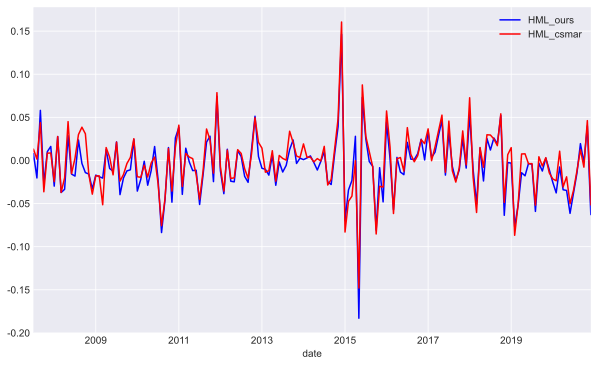

In [365]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.style.use('seaborn-dark')
compare.plot(ax=ax, kind='line', color=['b', 'r'],grid=True, legend=True)
plt.savefig("./figures/HML_compare.png", dpi=800)